# Psudo slit to measurent Halpha

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.ndimage import rotate

In [2]:
# Calculate pseudo slit flux using only H-alpha data
def calculate_flux_along_pseudo_slit(h_alpha_data, angle=None, width_slit=5, length_slit=20, max_width=100):
    if angle is not None:
        h_alpha_rot = rotate(h_alpha_data, angle, order=5)
    else:
        h_alpha_rot = h_alpha_data

    center_x, center_y = h_alpha_rot.shape[0] // 2, h_alpha_rot.shape[1] // 2
    pixels_conversion = 1
    
    # Calculate pseudo slit dimensions in the rotated image
    width_slit_new = int(width_slit / pixels_conversion)
    length_slit_new = int(length_slit / pixels_conversion)

    if width_slit < max_width and length_slit <= max_width:
        k = sum_flux = 0.0
        for i in range(center_x, center_x + length_slit_new):
            if (width_slit_new % 2) == 0:
                j_range = range(center_y - width_slit_new // 2, center_y + width_slit_new // 2)
            else:
                j_range = range(center_y - (width_slit_new - 1) // 2, center_y + (width_slit_new - 1) // 2 + 1)

            for j in j_range:
                if h_alpha_rot[i, j] > 0:  # Considering only positive H-alpha values
                    sum_flux += h_alpha_rot[i, j]
                    k += 1

    # Using these coordinates to estimate the pseudo slit coordinates
    pseudo_slit_coords = []

    # Generate coordinates along the pseudo slit
    for i in range(center_x, center_x + length_slit_new):
        if (width_slit_new % 2) == 0:
            j_range = range(center_y - width_slit_new // 2, center_y + width_slit_new // 2)
        else:
            j_range = range(center_y - (width_slit_new - 1) // 2, center_y + (width_slit_new - 1) // 2 + 1)

        for j in j_range:
            if h_alpha_rot[int(i), int(j)] > 0:  # Convert indices to integers
                pseudo_slit_coords.append([int(i), int(j)])  # Append integer indices to pseudo slit coordinates

        return sum_flux, k, pseudo_slit_coords

    else:
        print("Sorry, your slit width or/and length are larger than the true size of the image")
        return None

In [3]:
# Reading FITS file
hdu = fits.open("../maps_fits/b'iDR4_3_MC0114_0562811'_halpha_v1.fits")
hdu[0].data

array([[1.e-17, 1.e-17, 1.e-17, ..., 1.e-17, 1.e-17, 1.e-17],
       [1.e-17, 1.e-17, 1.e-17, ..., 1.e-17, 1.e-17, 1.e-17],
       [1.e-17, 1.e-17, 1.e-17, ..., 1.e-17, 1.e-17, 1.e-17],
       ...,
       [1.e-17, 1.e-17, 1.e-17, ..., 1.e-17, 1.e-17, 1.e-17],
       [1.e-17, 1.e-17, 1.e-17, ..., 1.e-17, 1.e-17, 1.e-17],
       [1.e-17, 1.e-17, 1.e-17, ..., 1.e-17, 1.e-17, 1.e-17]],
      dtype=float32)

In [4]:
data_haNii = hdu[0].data

In [5]:
# Assuming you have loaded the H-alpha data into the variable h_alpha_data

# Define the width and length of the pseudo-slit
width_slit = 5  # Example width of the slit
length_slit = 10  # Example length of the slit
max_width = 100  # Example maximum width for validation
angle = 60  # Example angle for rotation (set to None to avoid rotation)

In [6]:
# Calculate flux along the pseudo-slit
flux, spaxels_used, pseudo_slit_coords = calculate_flux_along_pseudo_slit(data_haNii, angle, width_slit, length_slit, max_width)

if flux is not None:
    print(f"Flux along pseudo-slit: {flux}")
    print(f"Number of spaxels used: {spaxels_used}")
    print(f"Coordinates of the slit: {pseudo_slit_coords}")
else:
    print("Flux calculation could not be performed due to slit size.")


Flux along pseudo-slit: 2.6409556643746324e-13
Number of spaxels used: 50.0
Coordinates of the slit: [[41, 39], [41, 40], [41, 41], [41, 42], [41, 43]]


In [7]:
# Assuming you have loaded the H-alpha data into the variable h_alpha_data

# Calculate flux along the pseudo-slit without rotating
flux1, spaxels_used1, pseudo_slit_coords1 = calculate_flux_along_pseudo_slit(data_haNii, width_slit=width_slit, length_slit=length_slit, max_width=max_width)

if flux1 is not None:
    print(f"Flux along pseudo-slit: {flux1}")
    print(f"Number of spaxels used: {spaxels_used1}")
    print(f"Coordinates of the slit: {pseudo_slit_coords1}")
else:
    print("Flux calculation could not be performed due to slit size.")


Flux along pseudo-slit: 4.3576057863991143e-13
Number of spaxels used: 50.0
Coordinates of the slit: [[30, 28], [30, 29], [30, 30], [30, 31], [30, 32]]


# Plotting

In [8]:
def plot_image_with_pseudo_slit(image_data, pseudo_slit_coords, width_slit):
    plt.figure(figsize=(8, 6))
    plt.imshow(image_data, cmap='gray')
    plt.colorbar(label='Intensity')

    # Extract x and y coordinates from pseudo_slit_coords
    x_coords = [coord[1] for coord in pseudo_slit_coords]
    y_coords = [coord[0] for coord in pseudo_slit_coords]

    # Plot the pseudo slit
    slit_segments = []
    for i in range(len(x_coords) - 1):
        x0, y0 = x_coords[i], y_coords[i]
        x1, y1 = x_coords[i + 1], y_coords[i + 1]

        # Calculate perpendicular offsets
        dx = x1 - x0
        dy = y1 - y0
        length = (dx**2 + dy**2)**0.5
        delta_x = width_slit * dy / length
        delta_y = width_slit * dx / length

        # Calculate coordinates for the slit edges
        slit_x = [x0 + delta_x, x1 + delta_x, x1 - delta_x, x0 - delta_x, x0 + delta_x]
        slit_y = [y0 - delta_y, y1 - delta_y, y1 + delta_y, y0 + delta_y, y0 - delta_y]

        slit_segments.extend(list(zip(slit_x, slit_y)))

    # Combine the segments to form a continuous slit
    slit_segments.append(slit_segments[0])  # Close the slit
    slit_segments = np.array(slit_segments)

    plt.plot(slit_segments[:, 0], slit_segments[:, 1], color='red')  # Plot the slit

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


In [9]:
#Plotting

In [10]:
pseudo_slit_coords

[[41, 39], [41, 40], [41, 41], [41, 42], [41, 43]]

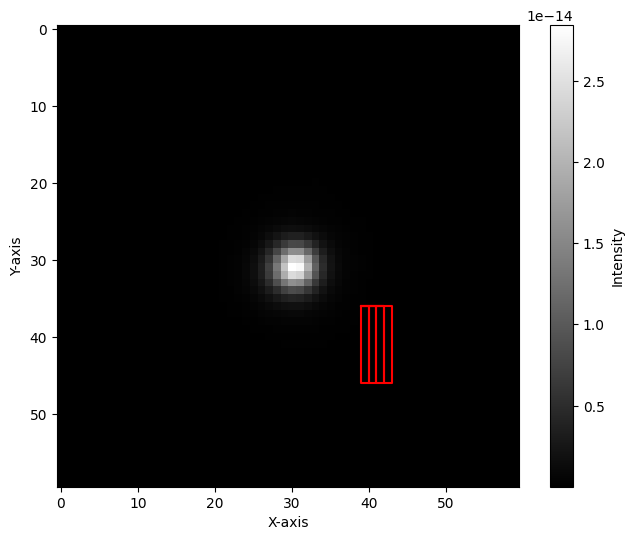

In [11]:
plot_image_with_pseudo_slit(data_haNii, pseudo_slit_coords, width_slit=width_slit)